# 🌾 Paddy Disease Classification using EfficientNet & Transfer Learning
<hr style="border:1px solid #ccc">

## 👨‍💻 Developed by: **Muhammad Haweras**

[![LinkedIn](https://img.shields.io/badge/LinkedIn-blue?logo=linkedin&logoColor=white)](https://www.linkedin.com/in/muhammad-haweras-7aa6b11b2/)
[![GitHub](https://img.shields.io/badge/GitHub-100000?logo=github&logoColor=white)](https://github.com/MuhammadHaweras)

<hr style="border:1px solid #ccc">

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

In [16]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the folder in your Google Drive
folder_path = '/content/drive/My Drive/balanced_images'

# Change the current working directory to the specified folder
os.chdir(folder_path)

# Verify the current working directory
print(f"Current working directory: {os.getcwd()}")

# List the contents of the folder
print("Contents of the folder:")
for item in os.listdir('.'):
    print(item)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory: /content/drive/My Drive/balanced_images
Contents of the folder:
normal
tungro
hispa
downy_mildew
brown_spot
bacterial_leaf_blight
bacterial_panicle_blight
bacterial_leaf_streak
dead_heart
blast
rice_disease_model.keras


### Let's  plot random images from dataset

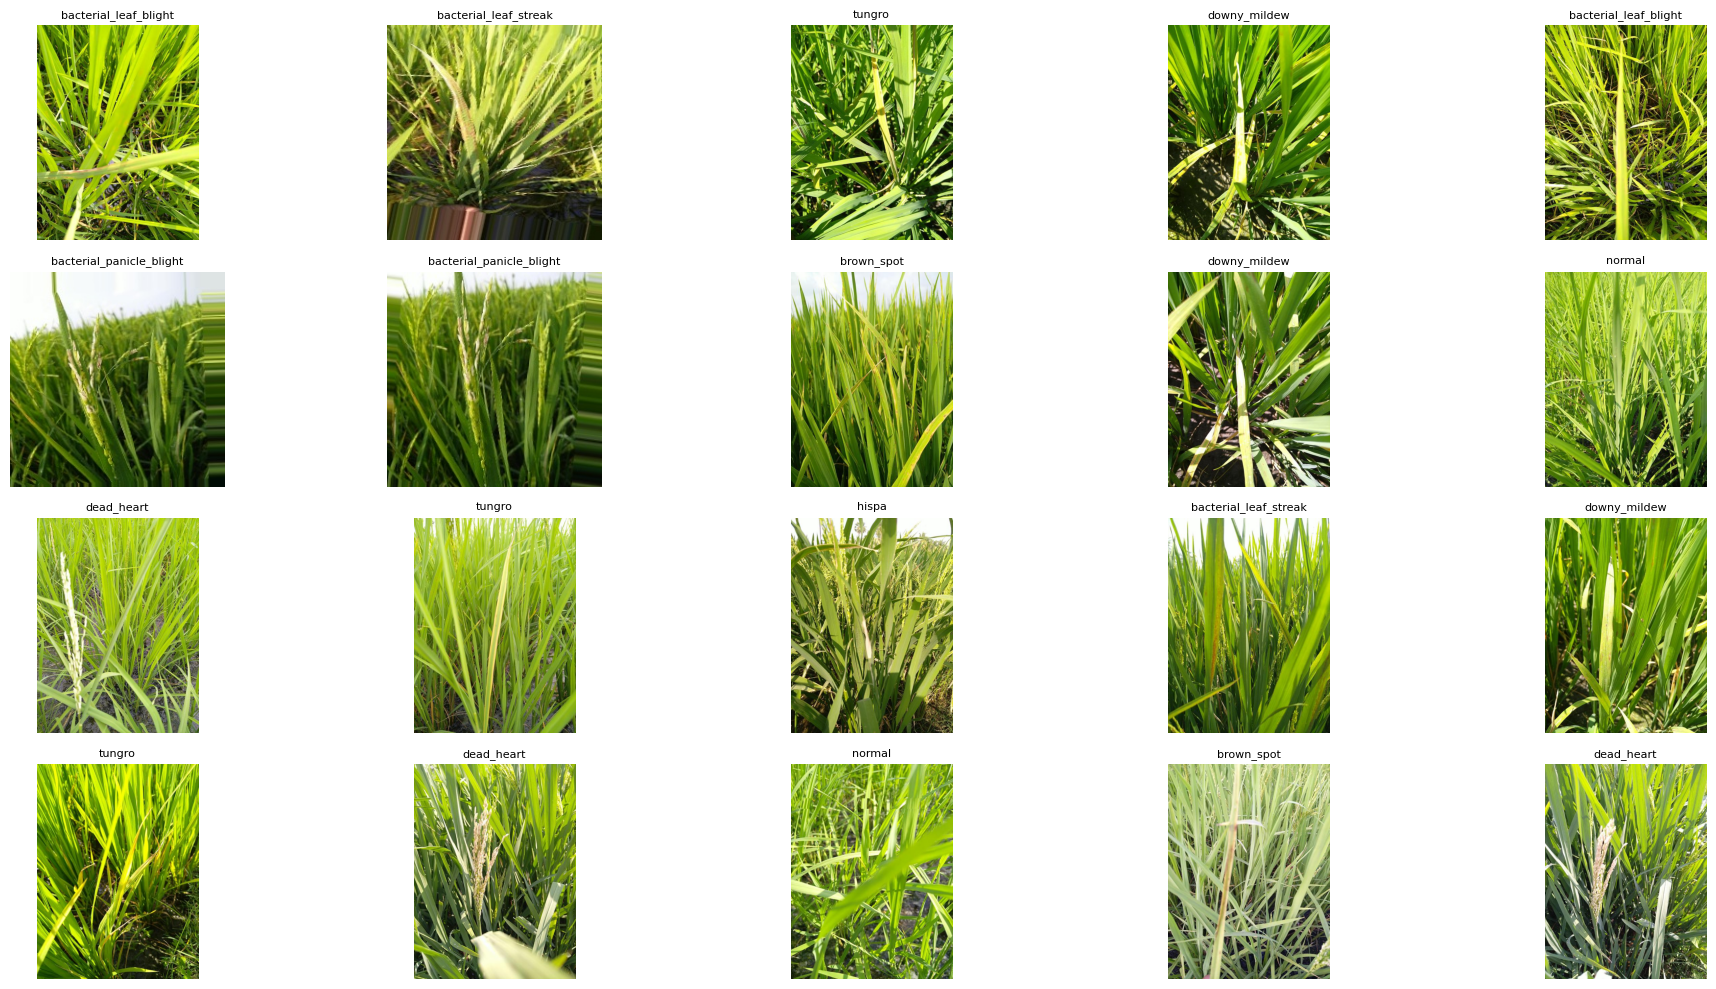

In [17]:
import random
import matplotlib.image as mpimg

data_dir = "."

# Collect all image paths with their label (folder name)
image_paths = []
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            if fname.lower().endswith((".png", ".jpg", ".jpeg")):
                image_paths.append((os.path.join(class_path, fname), class_name))

# Randomly select 20 images
selected_images = random.sample(image_paths, 20)

# Plot the images
plt.figure(figsize=(20, 10))
for idx, (img_path, label) in enumerate(selected_images):
    img = mpimg.imread(img_path)
    plt.subplot(4, 5, idx + 1)
    plt.imshow(img)
    plt.title(label, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Preparing Dataset

In [18]:
batch_size = 32
img_height = 300
img_width = 300
seed = 123

In [19]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 5010 files belonging to 10 classes.
Using 4008 files for training.


In [20]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 5010 files belonging to 10 classes.
Using 1002 files for validation.


In [21]:
class_names = train_ds.class_names
class_names

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [22]:
for image_batch, labels in train_ds.take(1):
		print(image_batch.shape)
		print(labels.shape)

(32, 300, 300, 3)
(32,)


In [23]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [24]:
num_classes = len(class_names)
num_classes

10

In [25]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input

### Data Augmentation

In [26]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomCrop(img_height, img_width),
])

## Model Building
<hr>

In [ ]:
base_model = EfficientNetB3(include_top=False, weights="imagenet", input_shape=(img_height, img_width, 3))
base_model.trainable = True

fine_tune_at = len(base_model.layers) - 20  # Unfreeze last 20 layers

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
base_output = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(base_output)

x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)


In [ ]:
model.compile(
	 optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
	metrics=['accuracy']
)

### Model Training

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,             # Stop after 20 epochs with no improvement
    restore_best_weights=True # Restore weights from best epoch
)

# Train the model
history_finetune = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=30,
    callbacks=[early_stop]
)


Epoch 1/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 85s 456ms/step - accuracy: 0.1291 - loss: 2.9443 - val_accuracy: 0.2794 - val_loss: 2.0955
Epoch 2/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 42s 335ms/step - accuracy: 0.2589 - loss: 2.3199 - val_accuracy: 0.4192 - val_loss: 1.7095
Epoch 3/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 42s 334ms/step - accuracy: 0.3293 - loss: 2.0480 - val_accuracy: 0.4671 - val_loss: 1.5287
Epoch 4/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 47s 373ms/step - accuracy: 0.3679 - loss: 1.9036 - val_accuracy: 0.4880 - val_loss: 1.4262
Epoch 5/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - accuracy: 0.4138 - loss: 1.7581 - val_accuracy: 0.5180 - val_loss: 1.3383
Epoch 6/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 45s 354ms/step - accuracy: 0.4537 - loss: 1.6121 - val_accuracy: 0.5379 - val_loss: 1.2897
Epoch 7/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 81s 336ms/step - accuracy: 0.4779 - loss: 1.5582 - val_accuracy: 0.5509 - val_loss: 1.2241
Epoch 8/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 42s 334ms/step - accuracy: 0.5055 - loss: 1

In [ ]:
history_continued = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=50,
    initial_epoch=30,  # Start from epoch 30
    callbacks=[early_stop]
)

Epoch 31/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 45s 350ms/step - accuracy: 0.8226 - loss: 0.5584 - val_accuracy: 0.7784 - val_loss: 0.7464
Epoch 32/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 43s 337ms/step - accuracy: 0.8069 - loss: 0.5782 - val_accuracy: 0.7854 - val_loss: 0.6857
Epoch 33/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - accuracy: 0.8223 - loss: 0.5339 - val_accuracy: 0.7764 - val_loss: 0.7273
Epoch 34/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 84s 346ms/step - accuracy: 0.8274 - loss: 0.5196 - val_accuracy: 0.7824 - val_loss: 0.7048
Epoch 35/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 43s 341ms/step - accuracy: 0.8394 - loss: 0.5025 - val_accuracy: 0.7705 - val_loss: 0.7472
Epoch 36/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 86s 368ms/step - accuracy: 0.8313 - loss: 0.5090 - val_accuracy: 0.7774 - val_loss: 0.7695
Epoch 37/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 43s 338ms/step - accuracy: 0.8432 - loss: 0.4957 - val_accuracy: 0.8064 - val_loss: 0.6292
Epoch 38/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 45s 358ms/step - accuracy: 0.8355 -

In [ ]:
history_continued_1 = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=60,
    initial_epoch=50,
    callbacks=[early_stop]
)

Epoch 51/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 49s 379ms/step - accuracy: 0.8750 - loss: 0.3730 - val_accuracy: 0.8453 - val_loss: 0.5196
Epoch 52/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 43s 338ms/step - accuracy: 0.8768 - loss: 0.3758 - val_accuracy: 0.8393 - val_loss: 0.5614
Epoch 53/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 42s 331ms/step - accuracy: 0.8945 - loss: 0.3276 - val_accuracy: 0.8293 - val_loss: 0.5814
Epoch 54/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 86s 358ms/step - accuracy: 0.8955 - loss: 0.3326 - val_accuracy: 0.8244 - val_loss: 0.5924
Epoch 55/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 42s 332ms/step - accuracy: 0.8819 - loss: 0.3492 - val_accuracy: 0.8184 - val_loss: 0.6091
Epoch 56/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 43s 343ms/step - accuracy: 0.8882 - loss: 0.3413 - val_accuracy: 0.8413 - val_loss: 0.5262
Epoch 57/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 42s 331ms/step - accuracy: 0.8901 - loss: 0.3159 - val_accuracy: 0.8244 - val_loss: 0.5947
Epoch 58/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 43s 337ms/step - accuracy: 0.8908 -

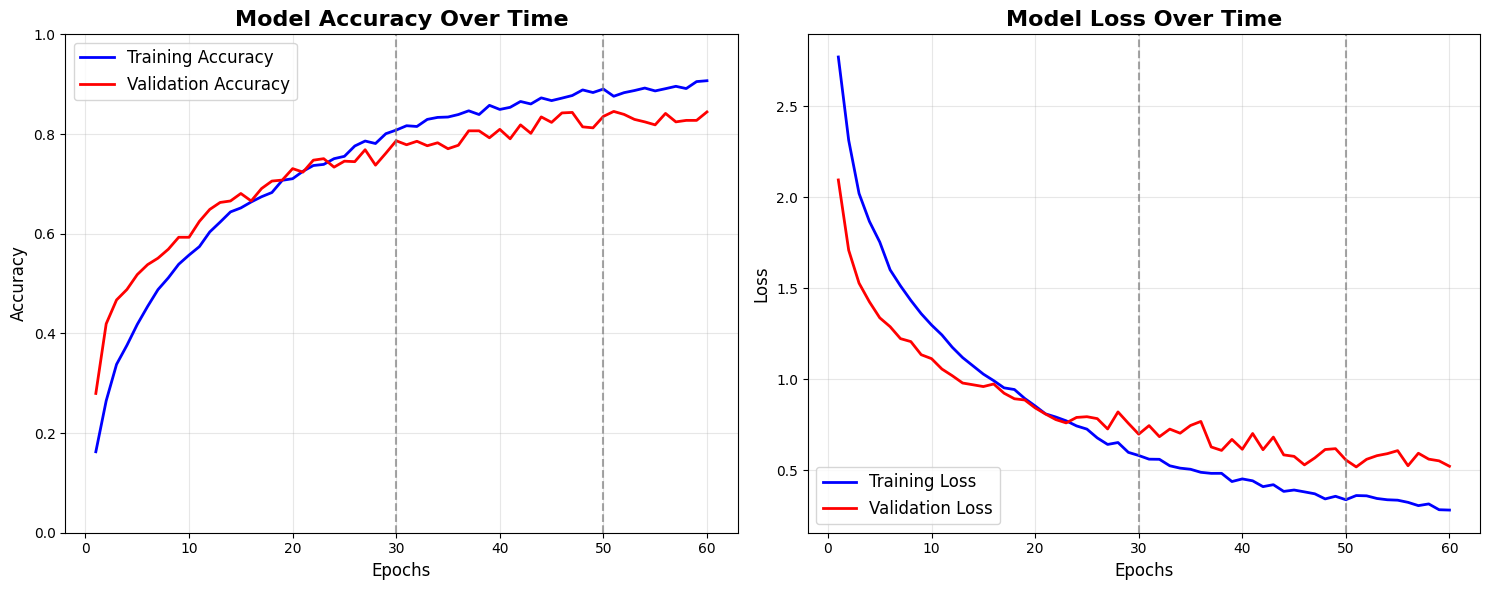

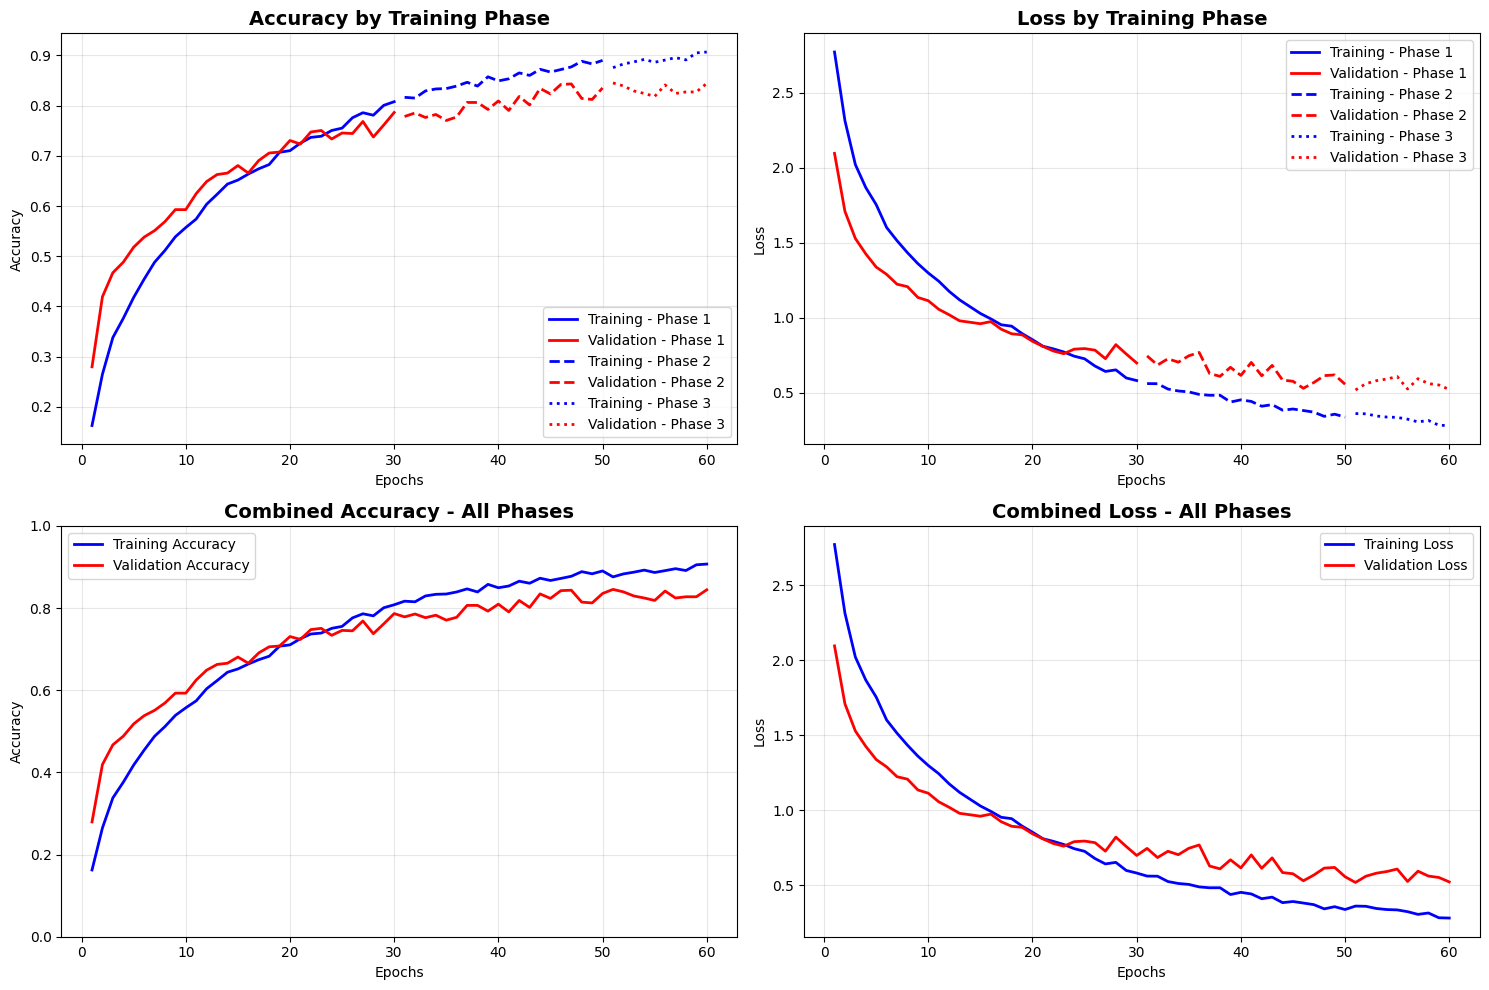


=== Phase-wise Performance ===

Phase 1 (Initial):
  Start Accuracy: Train=0.1624, Val=0.2794
  Final Accuracy: Train=0.8079, Val=0.7864
  Best Val Accuracy: 0.7864

Phase 2 (Continued):
  Start Accuracy: Train=0.8166, Val=0.7784
  Final Accuracy: Train=0.8902, Val=0.8353
  Best Val Accuracy: 0.8433

Phase 3 (Extended):
  Start Accuracy: Train=0.8757, Val=0.8453
  Final Accuracy: Train=0.9069, Val=0.8443
  Best Val Accuracy: 0.8453

=== Training Summary ===
Total Epochs: 60
Final Training Accuracy: 0.9069
Final Validation Accuracy: 0.8443
Final Training Loss: 0.2827
Final Validation Loss: 0.5233
Best Validation Accuracy: 0.8453
Best Validation Loss: 0.5196


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to combine multiple training histories
def combine_histories(*histories):
    """Combine multiple Keras training histories into one"""
    combined = {
        'accuracy': [],
        'val_accuracy': [],
        'loss': [],
        'val_loss': []
    }

    for history in histories:
        if hasattr(history, 'history'):
            hist_dict = history.history
        else:
            hist_dict = history

        for key in combined.keys():
            if key in hist_dict:
                combined[key].extend(hist_dict[key])

    return combined

combined_history = combine_histories(history_finetune, history_continued, history_continued_1)

# Create epochs array
total_epochs = len(combined_history['accuracy'])
epochs = range(1, total_epochs + 1)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Training and Validation Accuracy
ax1.plot(epochs, combined_history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
ax1.plot(epochs, combined_history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
ax1.set_title('Model Accuracy Over Time', fontsize=16, fontweight='bold')
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

# Add vertical lines to show training phases
if len(history_finetune.history['accuracy']) > 0:
    phase1_end = len(history_finetune.history['accuracy'])
    ax1.axvline(x=phase1_end, color='gray', linestyle='--', alpha=0.7, label='Phase 1 End')

if len(history_continued.history['accuracy']) > 0:
    phase2_end = phase1_end + len(history_continued.history['accuracy'])
    ax1.axvline(x=phase2_end, color='gray', linestyle='--', alpha=0.7, label='Phase 2 End')

# Plot 2: Training and Validation Loss
ax2.plot(epochs, combined_history['loss'], 'b-', label='Training Loss', linewidth=2)
ax2.plot(epochs, combined_history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
ax2.set_title('Model Loss Over Time', fontsize=16, fontweight='bold')
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)

# Add vertical lines to show training phases
if len(history_finetune.history['loss']) > 0:
    phase1_end = len(history_finetune.history['loss'])
    ax2.axvline(x=phase1_end, color='gray', linestyle='--', alpha=0.7)

if len(history_continued.history['loss']) > 0:
    phase2_end = phase1_end + len(history_continued.history['loss'])
    ax2.axvline(x=phase2_end, color='gray', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Plot individual phase comparison - FIXED LINE
fig2, ((ax3, ax4), (ax5, ax6)) = plt.subplots(2, 2, figsize=(15, 10))

# Phase-wise accuracy comparison
phase1_epochs = range(1, len(history_finetune.history['accuracy']) + 1)
phase2_epochs = range(len(history_finetune.history['accuracy']) + 1,
                     len(history_finetune.history['accuracy']) + len(history_continued.history['accuracy']) + 1)
phase3_epochs = range(len(history_finetune.history['accuracy']) + len(history_continued.history['accuracy']) + 1,
                     total_epochs + 1)

# Accuracy by phase
ax3.plot(phase1_epochs, history_finetune.history['accuracy'], 'b-', label='Training - Phase 1', linewidth=2)
ax3.plot(phase1_epochs, history_finetune.history['val_accuracy'], 'r-', label='Validation - Phase 1', linewidth=2)
if len(history_continued.history['accuracy']) > 0:
    ax3.plot(phase2_epochs, history_continued.history['accuracy'], 'b--', label='Training - Phase 2', linewidth=2)
    ax3.plot(phase2_epochs, history_continued.history['val_accuracy'], 'r--', label='Validation - Phase 2', linewidth=2)
if len(history_continued_1.history['accuracy']) > 0:
    ax3.plot(phase3_epochs, history_continued_1.history['accuracy'], 'b:', label='Training - Phase 3', linewidth=2)
    ax3.plot(phase3_epochs, history_continued_1.history['val_accuracy'], 'r:', label='Validation - Phase 3', linewidth=2)

ax3.set_title('Accuracy by Training Phase', fontsize=14, fontweight='bold')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Accuracy')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Loss by phase
ax4.plot(phase1_epochs, history_finetune.history['loss'], 'b-', label='Training - Phase 1', linewidth=2)
ax4.plot(phase1_epochs, history_finetune.history['val_loss'], 'r-', label='Validation - Phase 1', linewidth=2)
if len(history_continued.history['loss']) > 0:
    ax4.plot(phase2_epochs, history_continued.history['loss'], 'b--', label='Training - Phase 2', linewidth=2)
    ax4.plot(phase2_epochs, history_continued.history['val_loss'], 'r--', label='Validation - Phase 2', linewidth=2)
if len(history_continued_1.history['loss']) > 0:
    ax4.plot(phase3_epochs, history_continued_1.history['loss'], 'b:', label='Training - Phase 3', linewidth=2)
    ax4.plot(phase3_epochs, history_continued_1.history['val_loss'], 'r:', label='Validation - Phase 3', linewidth=2)

ax4.set_title('Loss by Training Phase', fontsize=14, fontweight='bold')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Loss')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Overall combined accuracy plot
ax5.plot(epochs, combined_history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
ax5.plot(epochs, combined_history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
ax5.set_title('Combined Accuracy - All Phases', fontsize=14, fontweight='bold')
ax5.set_xlabel('Epochs')
ax5.set_ylabel('Accuracy')
ax5.legend()
ax5.grid(True, alpha=0.3)
ax5.set_ylim(0, 1)

# Overall combined loss plot
ax6.plot(epochs, combined_history['loss'], 'b-', label='Training Loss', linewidth=2)
ax6.plot(epochs, combined_history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
ax6.set_title('Combined Loss - All Phases', fontsize=14, fontweight='bold')
ax6.set_xlabel('Epochs')
ax6.set_ylabel('Loss')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance metrics table
print("\n=== Phase-wise Performance ===")
phases = [
    ("Phase 1 (Initial)", history_finetune.history),
    ("Phase 2 (Continued)", history_continued.history),
    ("Phase 3 (Extended)", history_continued_1.history)
]

for phase_name, phase_history in phases:
    if len(phase_history.get('accuracy', [])) > 0:
        print(f"\n{phase_name}:")
        print(f"  Start Accuracy: Train={phase_history['accuracy'][0]:.4f}, Val={phase_history['val_accuracy'][0]:.4f}")
        print(f"  Final Accuracy: Train={phase_history['accuracy'][-1]:.4f}, Val={phase_history['val_accuracy'][-1]:.4f}")
        print(f"  Best Val Accuracy: {max(phase_history['val_accuracy']):.4f}")

# Print training summary
print("\n=== Training Summary ===")
print(f"Total Epochs: {total_epochs}")
print(f"Final Training Accuracy: {combined_history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {combined_history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {combined_history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {combined_history['val_loss'][-1]:.4f}")
print(f"Best Validation Accuracy: {max(combined_history['val_accuracy']):.4f}")
print(f"Best Validation Loss: {min(combined_history['val_loss']):.4f}")

In [ ]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 10, 10, 1536)   │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,394,383 (77.80 MB)

 Trainable params: 4,327,402 (16.51 MB)

 Non-trainable params: 7,412,175 (28.28 MB)

 Optimizer params: 8,654,806 (33.02 MB)

In [ ]:
model.save("/content/drive/MyDrive/balanced_images/rice_disease_model.keras")


## Making predictions with confidence Interval from our Trained Model

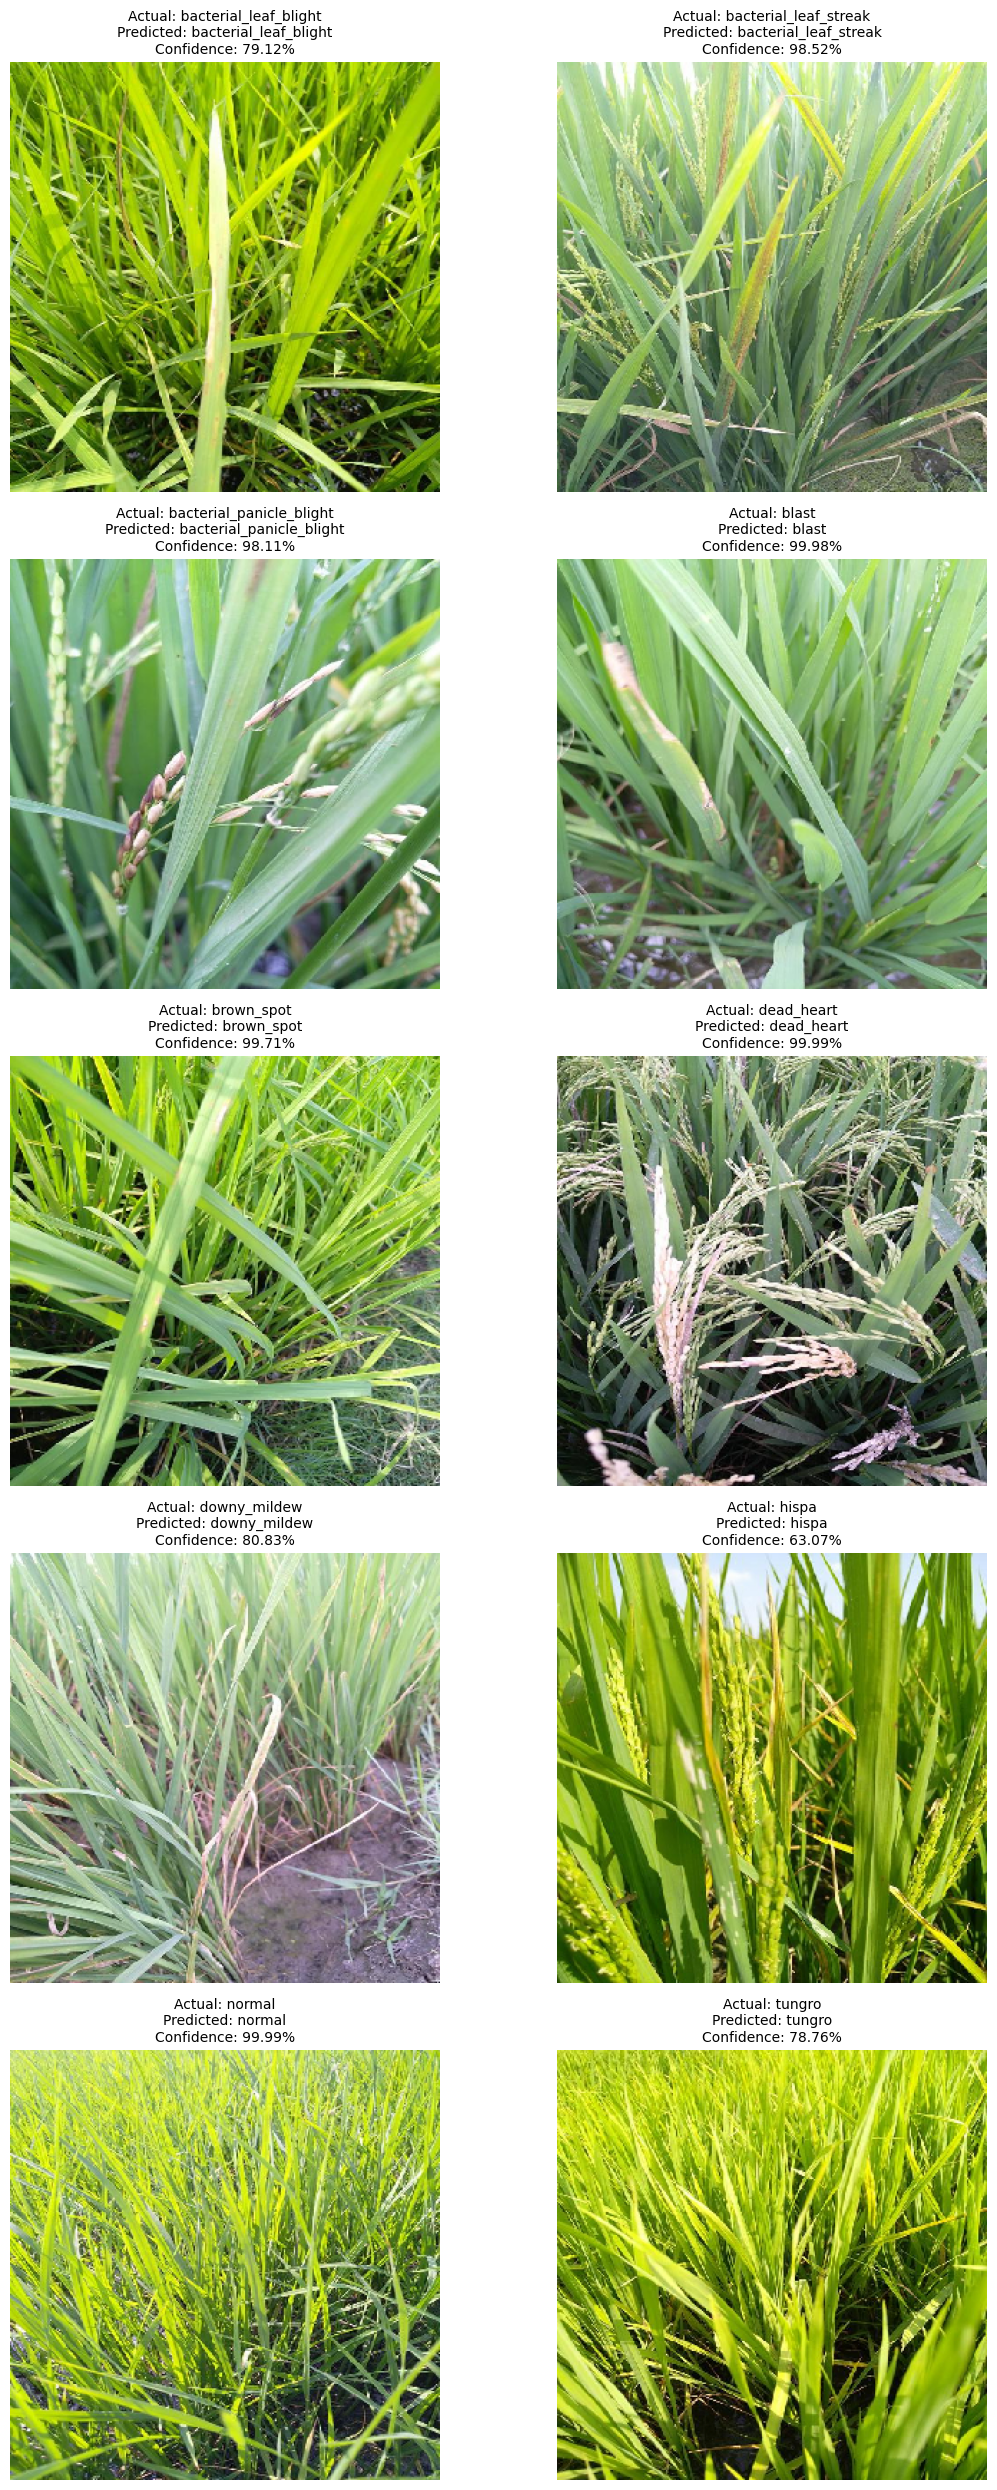

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

model_path = "/content/drive/MyDrive/balanced_images/rice_disease_model.keras"

model = tf.keras.models.load_model(model_path)
class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

# Pick one random image from each class
samples = []
for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if images:
        random_img = random.choice(images)
        samples.append((os.path.join(class_path, random_img), class_name))

# Predict and plot results
plt.figure(figsize=(12, 25))

for i, (img_path, actual_label) in enumerate(samples[:10]):  # limit to 10 images
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_batch = preprocess_input(img_batch)

    preds = model.predict(img_batch, verbose=0)
    predicted_index = np.argmax(preds)
    predicted_label = class_names[predicted_index]
    confidence = np.max(preds) * 100

    plt.subplot(5, 2, i + 1)  # 5 rows, 2 columns
    plt.imshow(np.array(img).astype("uint8"))
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}\nConfidence: {confidence:.2f}%", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Training Accuracy

In [32]:
train_loss, train_accuracy = model.evaluate(train_ds, verbose=0)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

Training Accuracy: 90.84%



> #### Validation Accuracy



In [31]:
loss, accuracy = model.evaluate(validation_ds)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

32/32 ━━━━━━━━━━━━━━━━━━━━ 254s 8s/step - accuracy: 0.8294 - loss: 0.5594
Validation Accuracy: 83.03%


### Confusion Matrix

In [28]:
from sklearn.metrics import confusion_matrix, classification_report

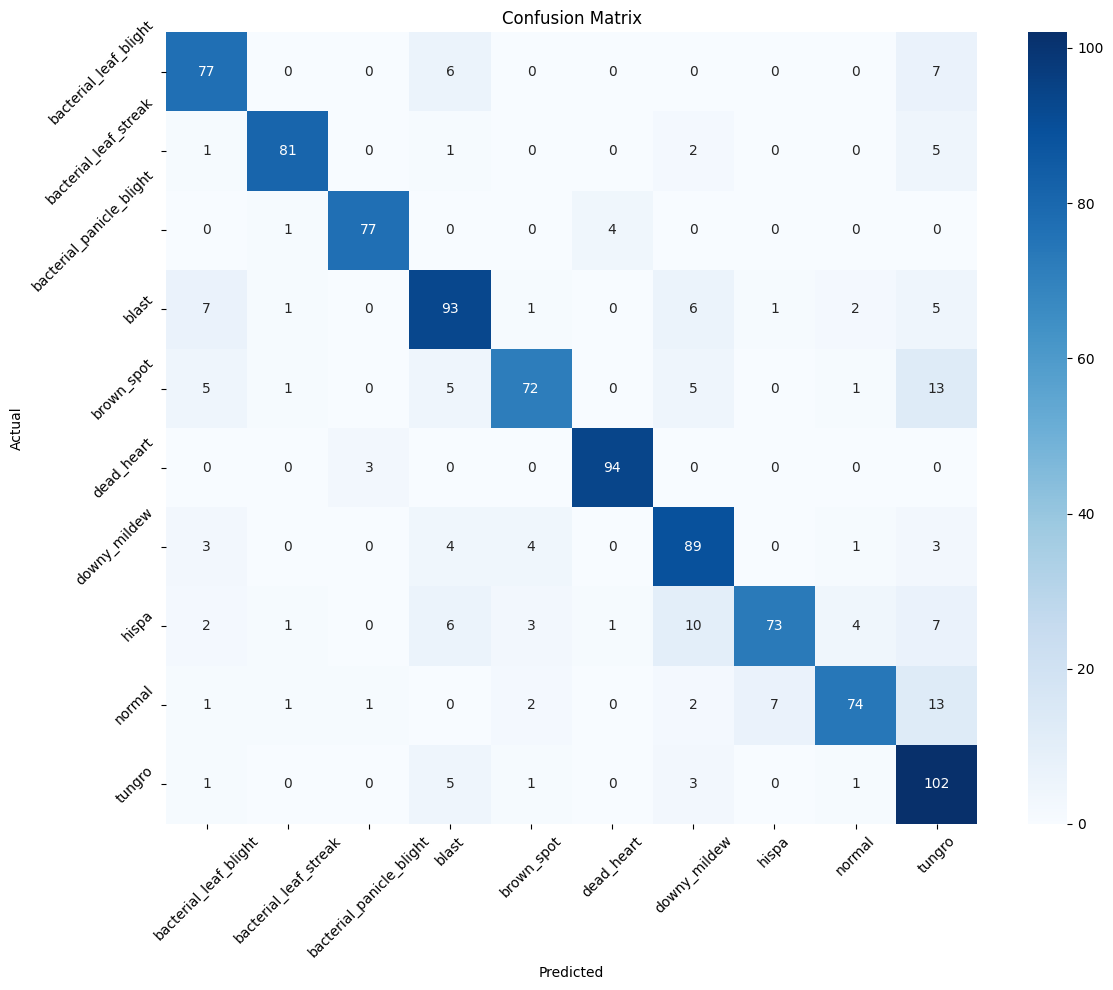

In [29]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

# --- Confusion matrix ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


### Classification Report

In [30]:
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n")
print(report)

Classification Report:

                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.79      0.86      0.82        90
   bacterial_leaf_streak       0.94      0.90      0.92        90
bacterial_panicle_blight       0.95      0.94      0.94        82
                   blast       0.78      0.80      0.79       116
              brown_spot       0.87      0.71      0.78       102
              dead_heart       0.95      0.97      0.96        97
            downy_mildew       0.76      0.86      0.81       104
                   hispa       0.90      0.68      0.78       107
                  normal       0.89      0.73      0.80       101
                  tungro       0.66      0.90      0.76       113

                accuracy                           0.83      1002
               macro avg       0.85      0.83      0.84      1002
            weighted avg       0.84      0.83      0.83      1002

